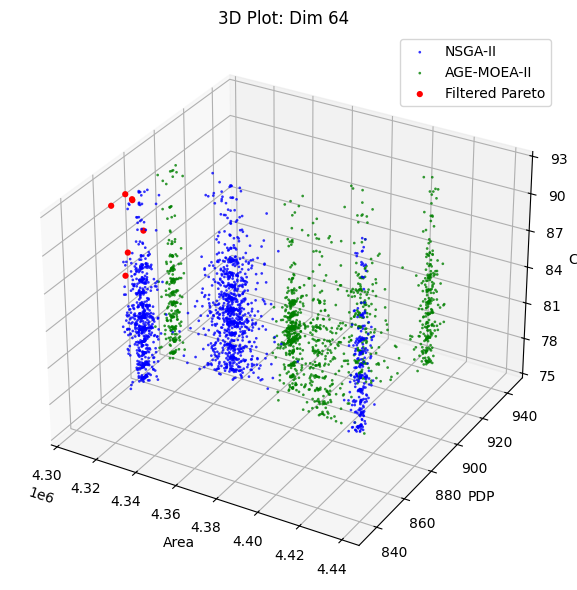

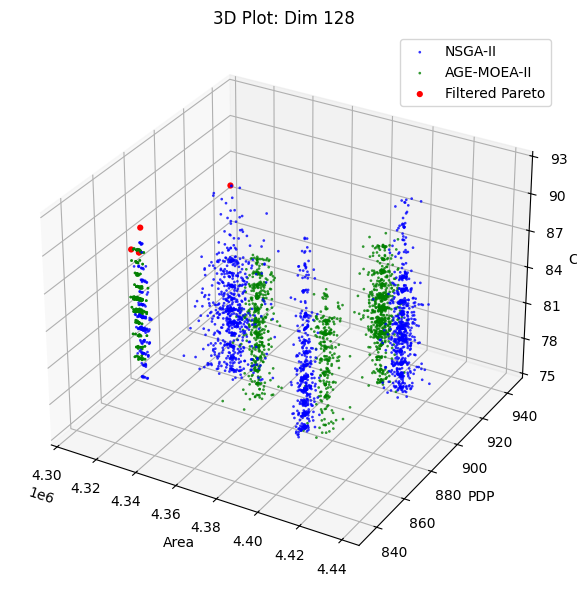

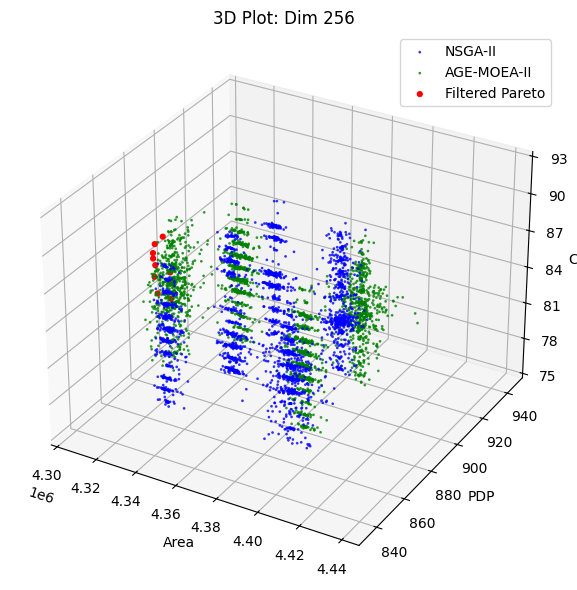

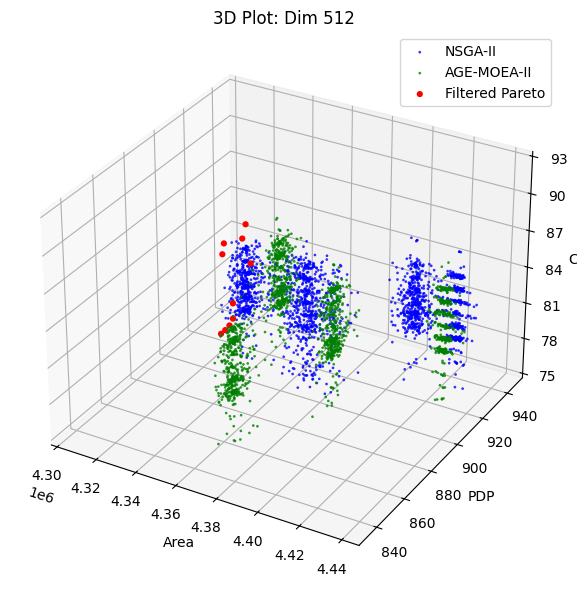

✅ All CNN plots and CSVs saved with updated legend labels.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

# ---------------- Threshold Filter ----------------
def filter_pareto_by_threshold(pareto_df, x_thresh, y_thresh, z_thresh):
    return pareto_df[
        (pareto_df['Area'] <= x_thresh) &
        (pareto_df['PDP'] <= y_thresh) &
        (pareto_df['CNN'] >= z_thresh)
    ]

# ---------------- Pareto Computation ----------------
def find_pareto_front(data, maximize_metric=True):
    def is_dominated(p1, p2):
        a1, d1, m1 = p1['Area'], p1['PDP'], p1['CNN']
        a2, d2, m2 = p2['Area'], p2['PDP'], p2['CNN']

        if maximize_metric:
            better_eq = a2 <= a1 and d2 <= d1 and m2 >= m1
            strict = a2 < a1 or d2 < d1 or m2 > m1
        else:
            better_eq = a2 <= a1 and d2 <= d1 and m2 <= m1
            strict = a2 < a1 or d2 < d1 or m2 < m1

        return better_eq and strict

    pareto_front = []
    for p1 in data:
        if not any(is_dominated(p1, p2) for p2 in data if p2 != p1):
            pareto_front.append(p1)
    return pareto_front

# ---------------- Configuration ----------------
csv_files = [
    "generated_64.csv",
    "generated_128.csv",
    "generated_256.csv",
    "generated_512.csv"
]
titles = ["Dim 64", "Dim 128", "Dim 256", "Dim 512"]

# Label mapping
label_legend_map = {
    'set1': 'NSGA-II',
    'set2': 'AGE-MOEA-II'
}
color_map = {'set1': 'blue', 'set2': 'green'}
common_marker = '.'

# Thresholds for filtered Pareto
x_thresh = 4380000
y_thresh = 930
z_thresh = 87  # CNN threshold

# ---------------- Create Individual Plots ----------------
for i, (csv, title) in enumerate(zip(csv_files, titles)):
    df = pd.read_csv(csv)
    filtered_df = df[df['Label'].isin(label_legend_map.keys())].copy()
    data_list = filtered_df[['Area', 'PDP', 'CNN']].to_dict('records')

    # Add index
    for j, row in enumerate(data_list):
        row['index'] = filtered_df.index[j]

    pareto_points = find_pareto_front(data_list, maximize_metric=True)
    pareto_indices = [p['index'] for p in pareto_points]
    pareto_df = df.loc[pareto_indices]

    # Filtered Pareto points
    filtered_pareto = filter_pareto_by_threshold(pareto_df, x_thresh, y_thresh, z_thresh)
    if len(filtered_pareto) > 10:
        filtered_pareto = filtered_pareto.sample(n=10, random_state=42)

    # Save filtered Pareto to CSV
    dim = csv.split('_')[-1].split('.')[0]
    output_csv = f'CSV_pareto_{dim}.csv'
    filtered_pareto.to_csv(output_csv, index=False)

    # Plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    for label, color in color_map.items():
        subset = df[(df['Label'] == label) & (~df.index.isin(pareto_indices))]
        ax.scatter(subset['Area'], subset['PDP'], subset['CNN'],
                   c=color, marker=common_marker, s=15,
                   label=label_legend_map[label],
                   alpha=0.8, edgecolor='none')

    # Plot filtered Pareto points
    ax.scatter(filtered_pareto['Area'], filtered_pareto['PDP'], filtered_pareto['CNN'],
               c='red', marker='o', s=20, label='Filtered Pareto',
               alpha=1.0, edgecolors='none')

    # Axes and titles
    ax.set_xlim(4300000, 4445000)
    ax.set_ylim(830, 950)
    ax.set_zlim(75, 93)
    ax.set_zticks(list(range(75, 94, 3)))
    ax.set_xlabel('Area')
    ax.set_ylabel('PDP')
    ax.set_zlabel('CNN')
    ax.set_title(f'3D Plot: {title}')
    ax.legend()

    # Save individual figure
    output_plot = f'plot_{dim}_cnn.png'
    plt.tight_layout()
    plt.savefig(output_plot)
    plt.show()
    plt.close()

print("✅ All CNN plots and CSVs saved with updated legend labels.")
